In [ ]:
# !pip install qiskit qiskit-aer pylatexenc

In [ ]:
# Steane Code Steps:
# ------------------------
# 1. Encoding
# 2. Noise
# 3. Syndrome Measurement
# 4. Correction
# 5. Decoding

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector

import numpy as np

from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

%matplotlib inline

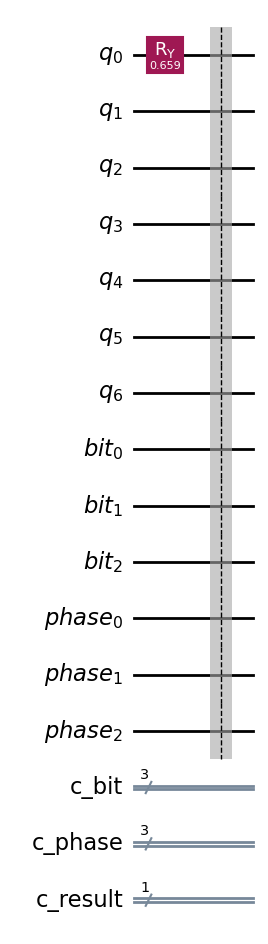

In [ ]:
# ========================================
# STEP 1: STEUP
# ========================================
q = QuantumRegister(7, 'q')
q_bit = QuantumRegister(3, 'bit')
q_phase = QuantumRegister(3, 'phase')
c_bit = ClassicalRegister(3, 'c_bit')
c_phase = ClassicalRegister(3, 'c_phase')
c_res = ClassicalRegister(1, 'c_result')

qc = QuantumCircuit(q, q_bit, q_phase, c_bit, c_phase, c_res)



# ========================================
# STEP 2: STATE INITIALIZATION (RANDOM)
# ========================================
u = np.random.uniform(0, 1)
theta = np.arccos(u)
qc.ry(theta, q[0])
qc.barrier()



# circuit plotting
fig = qc.draw("mpl", fold=-1)
fig.set_size_inches(40, 12)
fig


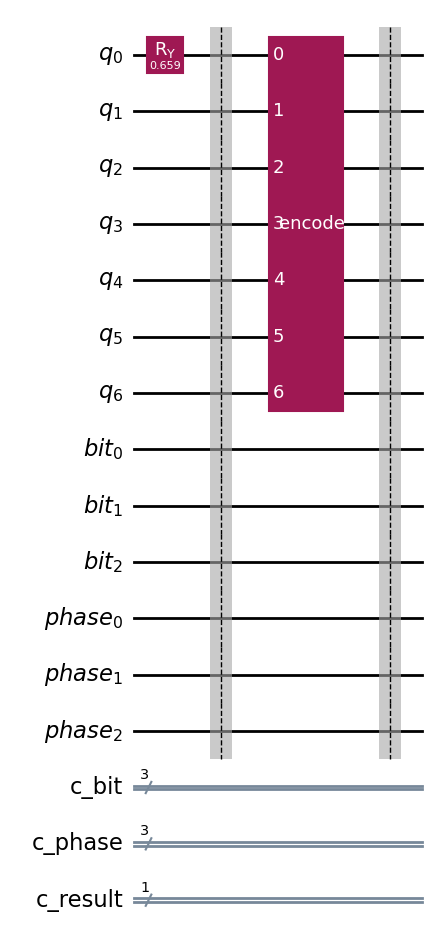

In [ ]:
# ========================================
# STEP 3: ENCODING
# ========================================
def steane_encode():
      """Return a QuantumCircuit that encodes q0 into the 7-qubit Steane code."""
      qr = QuantumRegister(7, 'q')
      qc = QuantumCircuit(qr, name='encode')

      # create superposition
      for i in range(4,7):
          qc.h(i)

      # create entanglement
      pairs= [(0, 1), (0, 2),
              (6, 0), (6, 1), (6, 3),
              (5, 0), (5, 2), (5, 3),
              (4, 1), (4, 2), (4, 3)]
      for a, b in pairs:
          qc.cx(a, b)
      return qc

qc.append(steane_encode().to_gate(), q)
qc.barrier()





# circuit plotting
# fig = qc.decompose().draw("mpl", fold=-1)
fig = qc.draw("mpl", fold=-1)
fig.set_size_inches(40, 12)
fig


Injected X on q1


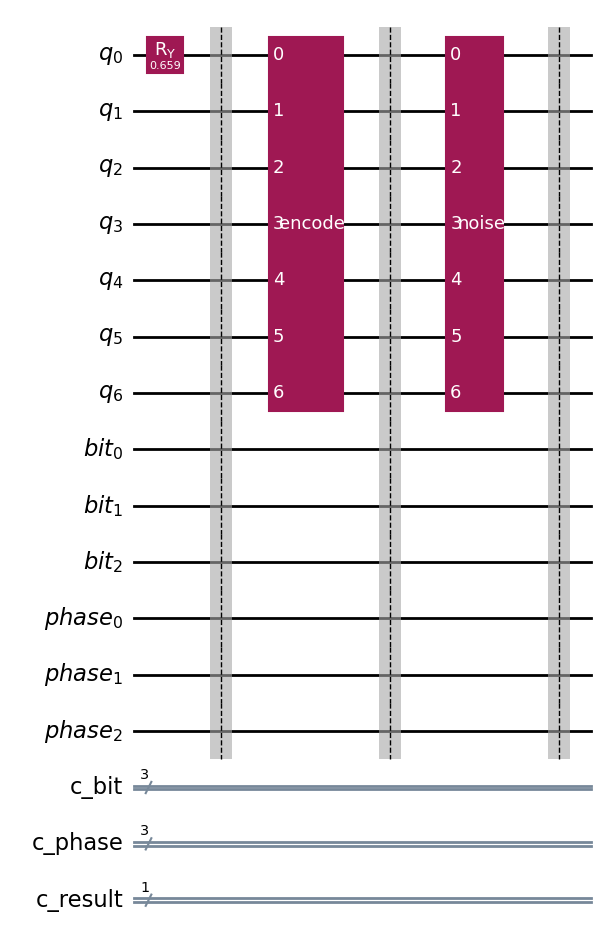

In [ ]:
# ========================================
# STEP 4: Apply Noise
# ========================================
def apply_noise():
    """
    Apply a single-qubit Pauli error (X, Y, Z) or identity (I) on one of the 7 data qubits.
    If error_qubit is None, no error is applied.
    """
    qr = QuantumRegister(7, 'q')
    qc = QuantumCircuit(qr, name='noise')
    gate_arr = ['id', 'x', 'y', 'z']
    gate = np.random.choice(gate_arr)

    idx = np.random.randint(0, 7)
    print(f"Injected {gate.upper()} on q{idx}")

    getattr(qc, gate)(q[idx])

    return qc

qc.append(apply_noise().to_gate(), q)
qc.barrier()




# circuit plotting
# fig = qc.decompose().draw("mpl", fold=-1)
fig = qc.draw("mpl", fold=-1)
fig.set_size_inches(40, 12)
fig

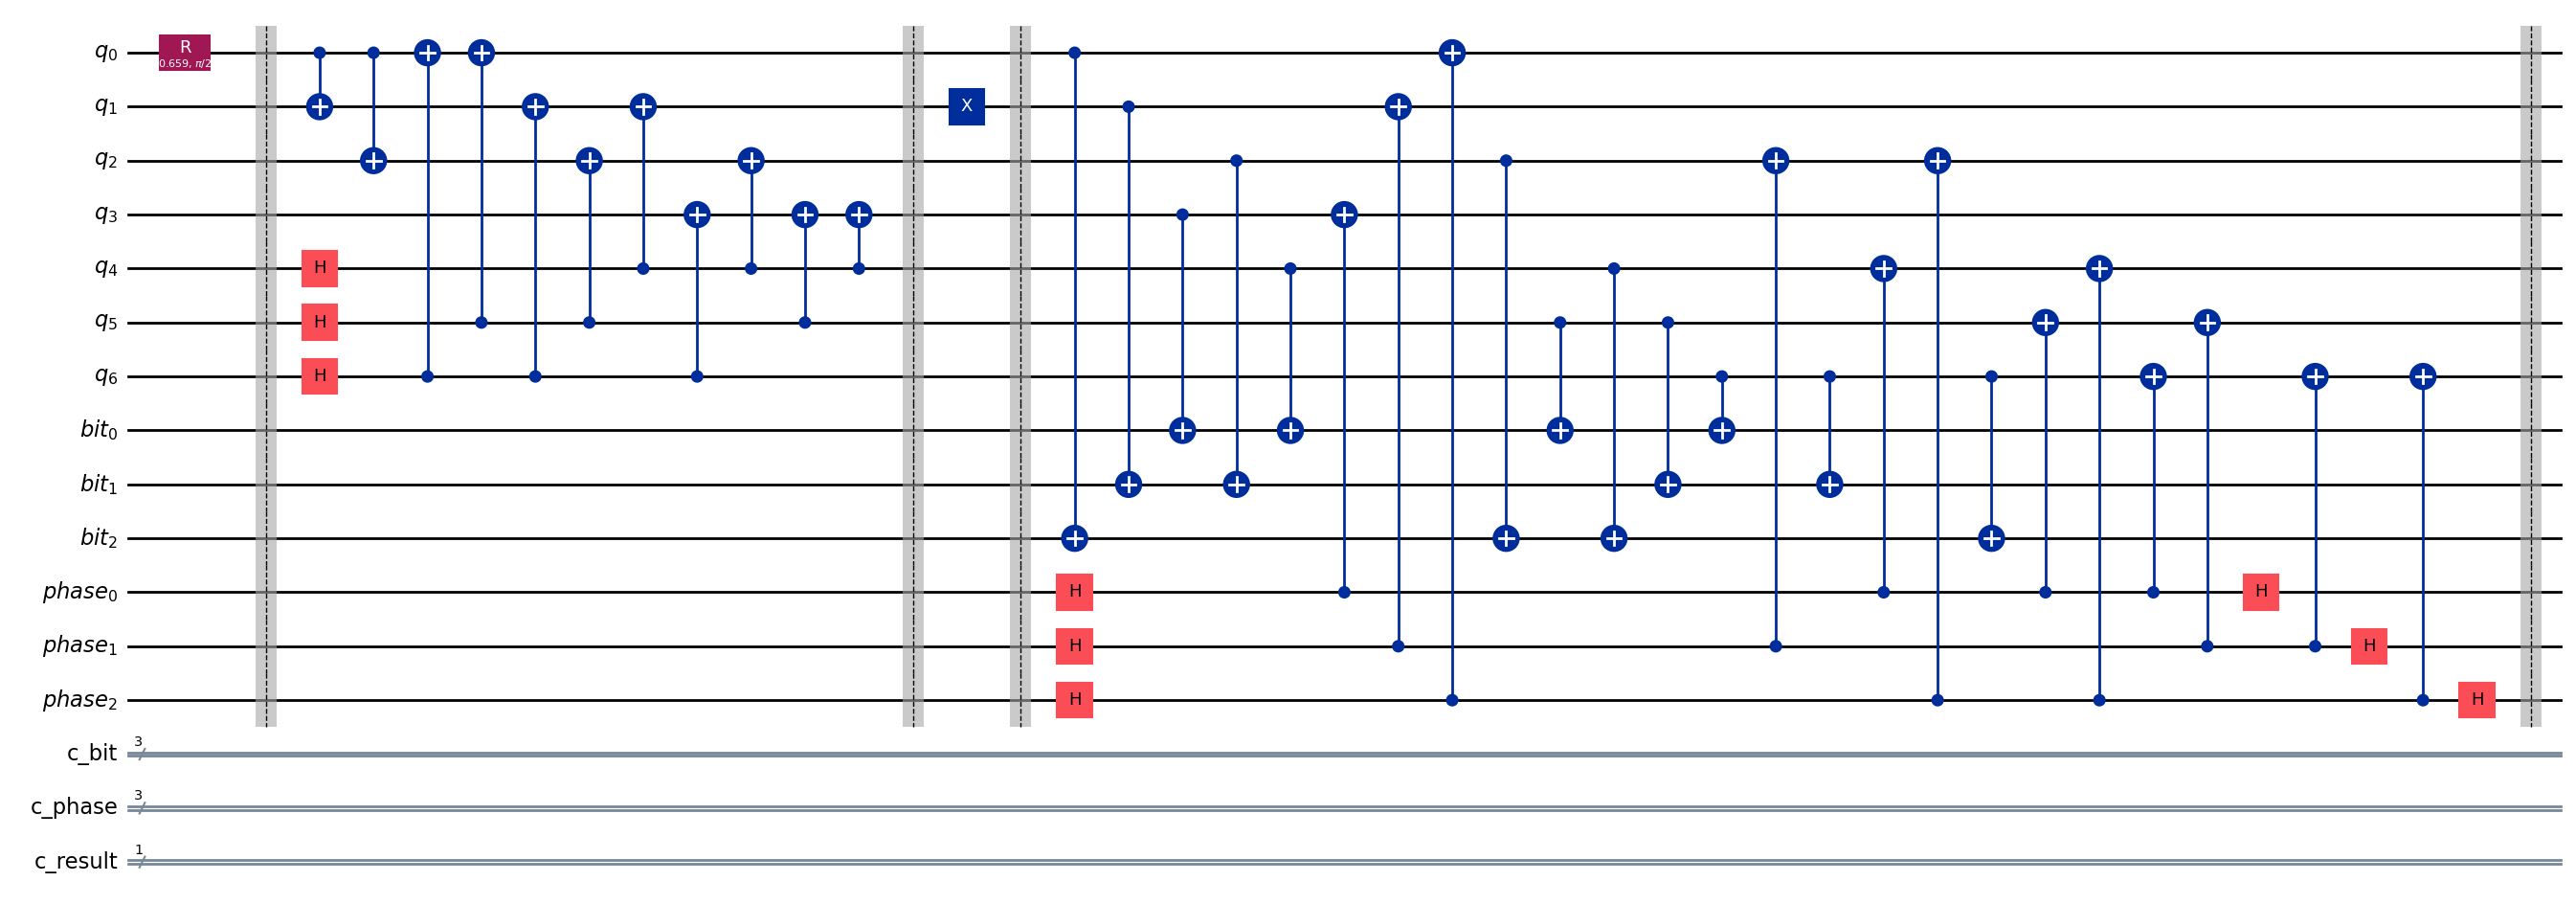

In [ ]:
def steane_syndrome_circuit():
    """
    Return a circuit that measures Steane bit-flip and phase-flip syndromes.
    Data qubits: q[0..6]
    Bit ancillas: a_b[0..2]
    Phase ancillas: a_p[0..2]
    """
    data = QuantumRegister(7, 'data')
    a_b = QuantumRegister(3, 'bit')
    a_p = QuantumRegister(3, 'phase')

    qc = QuantumCircuit(data, a_b, a_p, name='syndrome')

    # --- Bit-flip (Z-type) stabilizers: measure Z patterns with CNOTs onto |0> ancillas ---
    # Z4 Z5 Z6 Z7, Z2 Z3 Z6 Z7, Z1 Z3 Z5 Z7  -> indices (3,4,5,6), (1,2,5,6), (0,2,4,6)

    # Stabilizer 1
    for q in [3, 4, 5, 6]:
        qc.cx(data[q], a_b[0])

    # Stabilizer 2
    for q in [1, 2, 5, 6]:
        qc.cx(data[q], a_b[1])

    # Stabilizer 3
    for q in [0, 2, 4, 6]:
        qc.cx(data[q], a_b[2])

    # --- Phase-flip (X-type) stabilizers: put ancillas in |+>, use CNOT reverse direction, then measure in X basis ---
    qc.h(a_p)

    # X4 X5 X6 X7, X2 X3 X6 X7, X1 X3 X5 X7
    for q in [3, 4, 5, 6]:
        qc.cx(a_p[0], data[q])

    for q in [1, 2, 5, 6]:
        qc.cx(a_p[1], data[q])

    for q in [0, 2, 4, 6]:
        qc.cx(a_p[2], data[q])
    qc.h(a_p)


    return qc

qc.append(steane_syndrome_circuit().to_gate(), list(q) + list(q_bit) + list(q_phase))
qc.barrier()




# circuit plotting
fig = qc.decompose().draw("mpl", fold=-1)
# fig = qc.draw("mpl", fold=-1)
fig.set_size_inches(40, 12)
fig

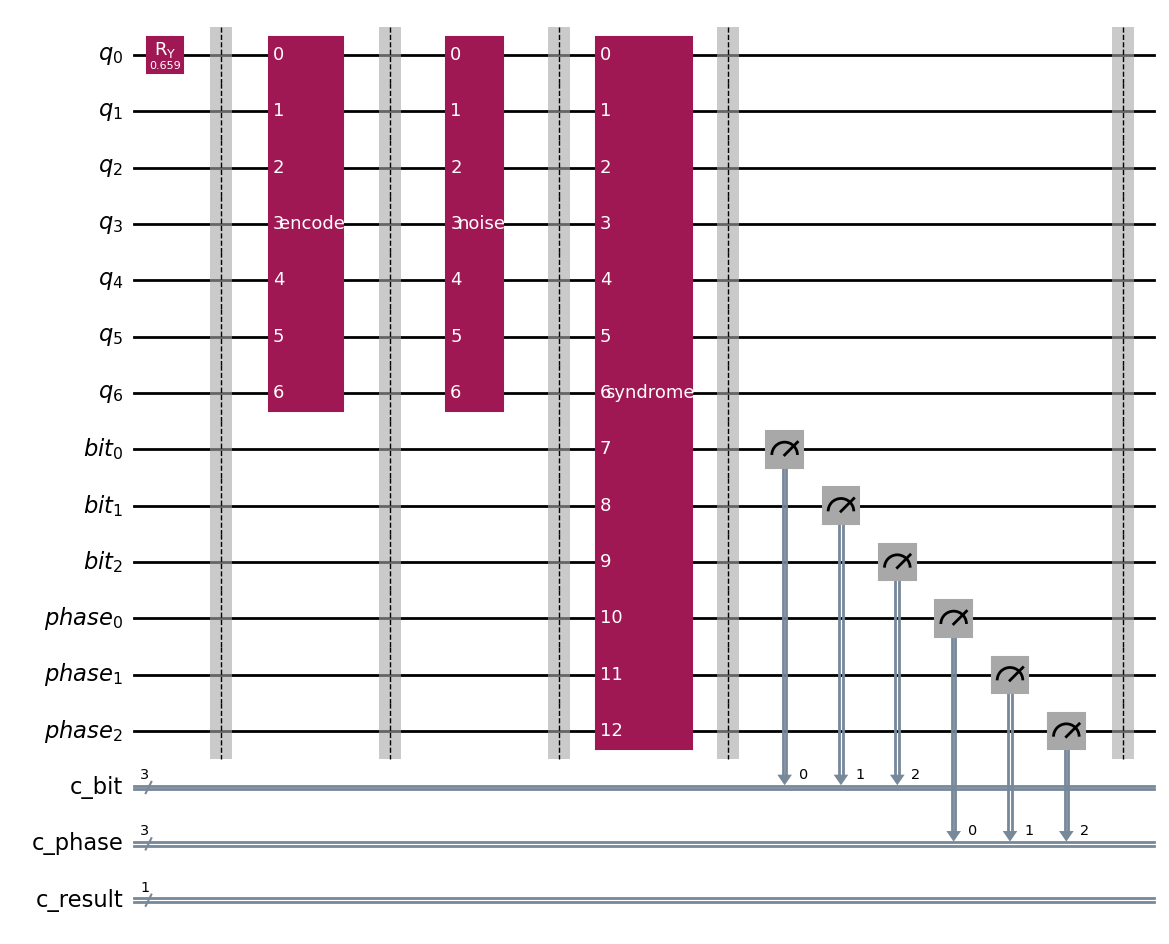

In [ ]:
# ========================================
# STEP 6: SYNDROME MEASUREMENT
# ========================================
qc.measure(q_bit, c_bit)
qc.measure(q_phase, c_phase)
qc.barrier()


# circuit plotting
# fig = qc.decompose().draw("mpl", fold=-1)
fig = qc.draw("mpl", fold=-1)
fig.set_size_inches(40, 12)
fig

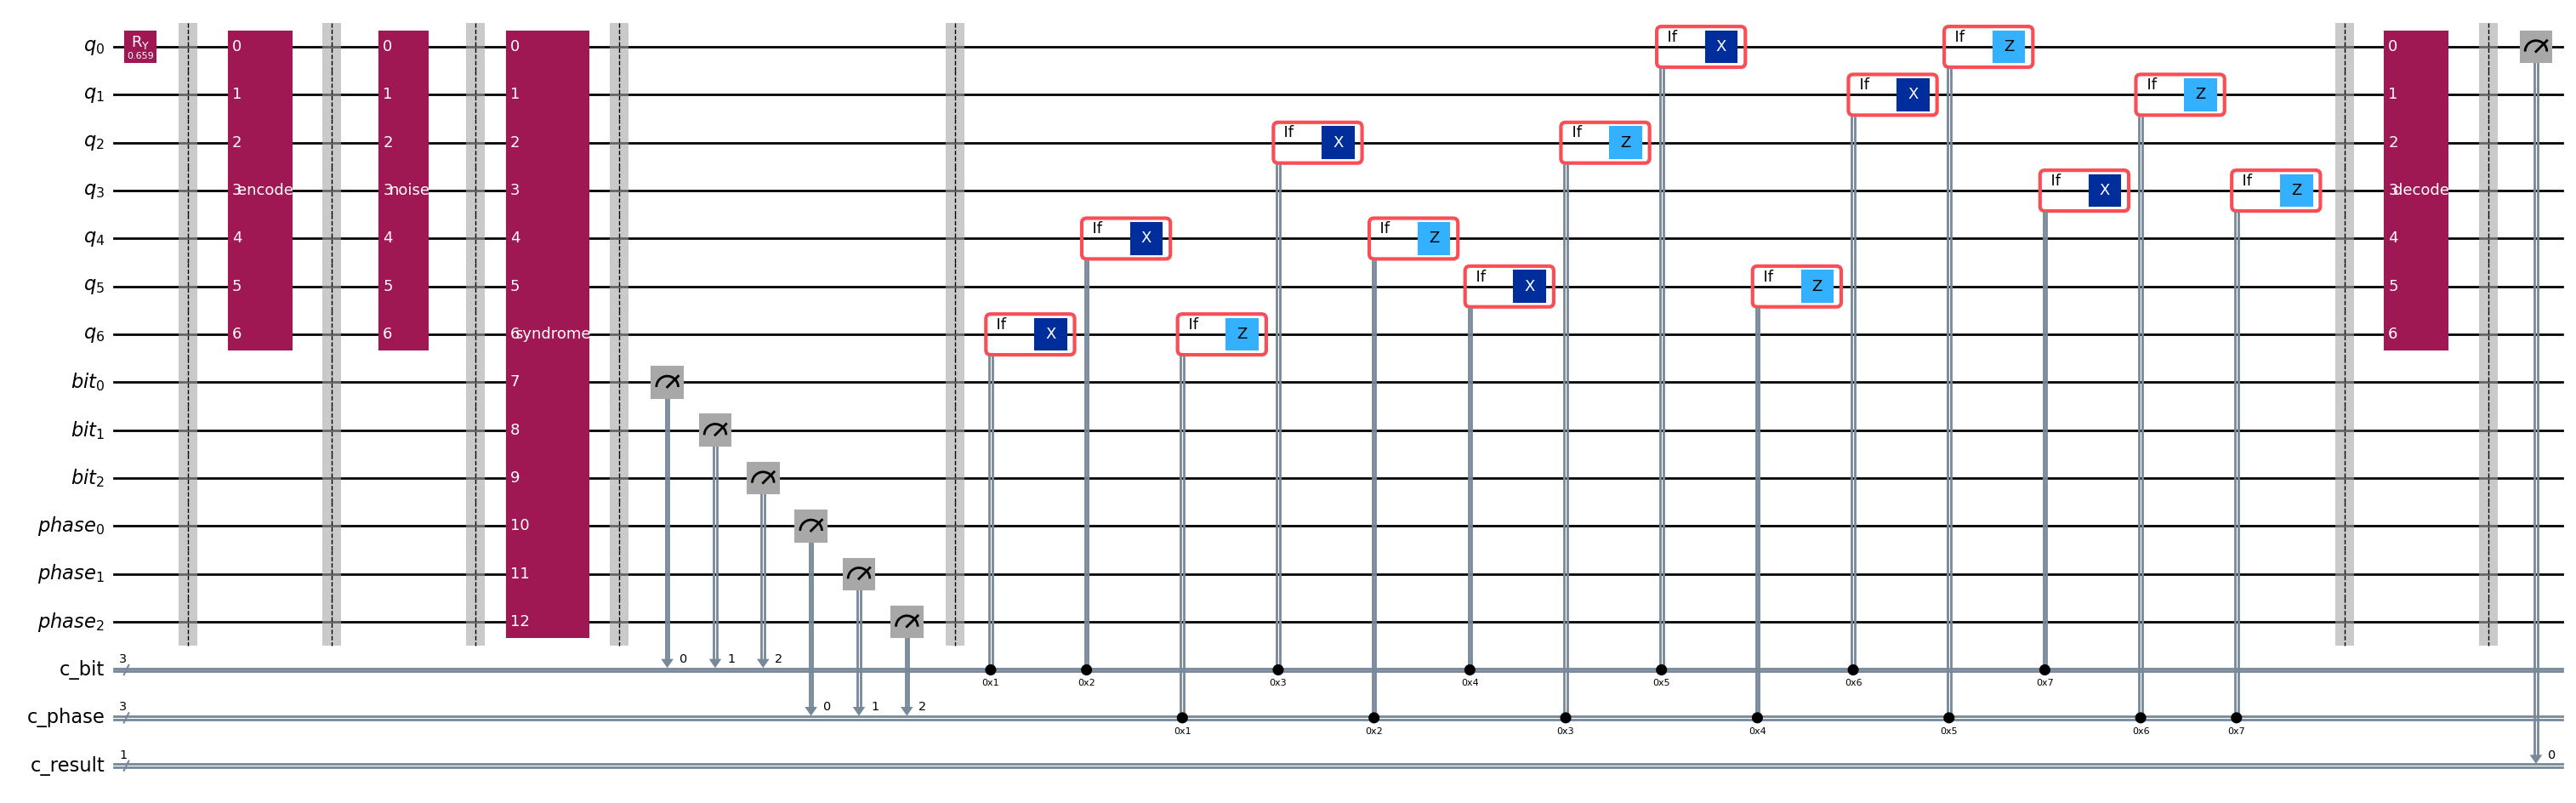

In [ ]:

# ========================================
# STEP 7: Correction
# ========================================
BIT_SYNDROME_TO_QUBIT = {
    0b000: None,
    0b001: 6,
    0b010: 4,
    0b011: 2,
    0b100: 5,
    0b101: 0,
    0b110: 1,
    0b111: 3,
}

PHASE_SYNDROME_TO_QUBIT = {
    0b000: None,
    0b001: 6,
    0b010: 4,
    0b011: 2,
    0b100: 5,
    0b101: 0,
    0b110: 1,
    0b111: 3,
}

# ======= Apply Correction =======
def steane_correct(qc, q, c_bit, c_phase):
    for s, qb in BIT_SYNDROME_TO_QUBIT.items():
        if qb is not None:
            with qc.if_test((c_bit, s)):
                qc.x(q[qb])
    for s, qb in PHASE_SYNDROME_TO_QUBIT.items():
        if qb is not None:
            with qc.if_test((c_phase, s)):
                qc.z(q[qb])
    return qc

steane_correct(qc, q, c_bit, c_phase)
qc.barrier()


# ======= Decode back =======
def steane_decode():
    """Inverse of the encoder."""
    encode = steane_encode()
    decode = encode.inverse()
    decode.name = 'decode'
    return decode
qc.append(steane_decode().to_gate(), q)
qc.barrier()

# ======= Final state measurement =======
qc.measure(q[0], c_res)


# circuit plotting
fig = qc.draw("mpl", fold=-1)
fig.set_size_inches(40, 12)
fig

{'1 000 010': 209, '0 000 010': 1839}

Theoretical P(0):  0.8954
Experimental P(0): 0.8979
Success:  99.7455%
Detected Z-Syndrome (c_bit): 010
Detected X-Syndrome (c_phase): 000


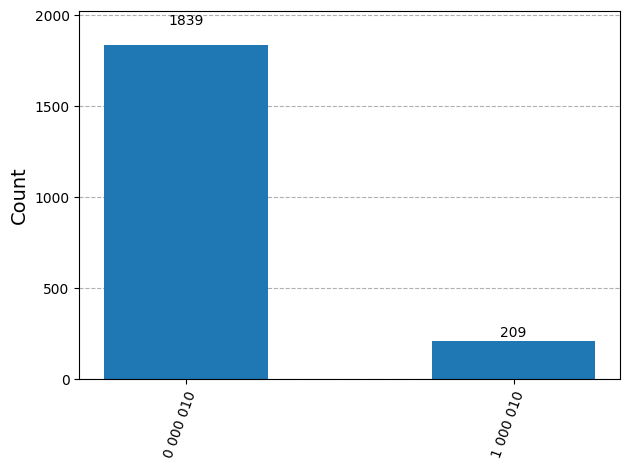

In [ ]:
# =========================================
# 8. Execution & Analysis
# =========================================
sim = AerSimulator()
t_qc = transpile(qc, sim)
shots = 2048
counts = sim.run(t_qc, shots=shots).result().get_counts()
print(counts)


# ======= Calculate P(0) Theoretical vs Experimental =======
p0_theory = (u + 1) / 2
count_0 = sum(count for key, count in counts.items() if key.split()[0] == '0')
p0_exp = count_0 / shots

print("\n" + "="*50)
print(f"Theoretical P(0):  {p0_theory:.4f}")
print(f"Experimental P(0): {p0_exp:.4f}")
print(f"Success:  {(1 - abs(p0_theory - p0_exp)):.4%}")
print("="*50)

# ======= Z/X syndrome =======
sample_bits = max(counts, key=counts.get).split()
print(f"Detected Z-Syndrome (c_bit): {sample_bits[2]}")
print(f"Detected X-Syndrome (c_phase): {sample_bits[1]}")

plot_histogram(counts)


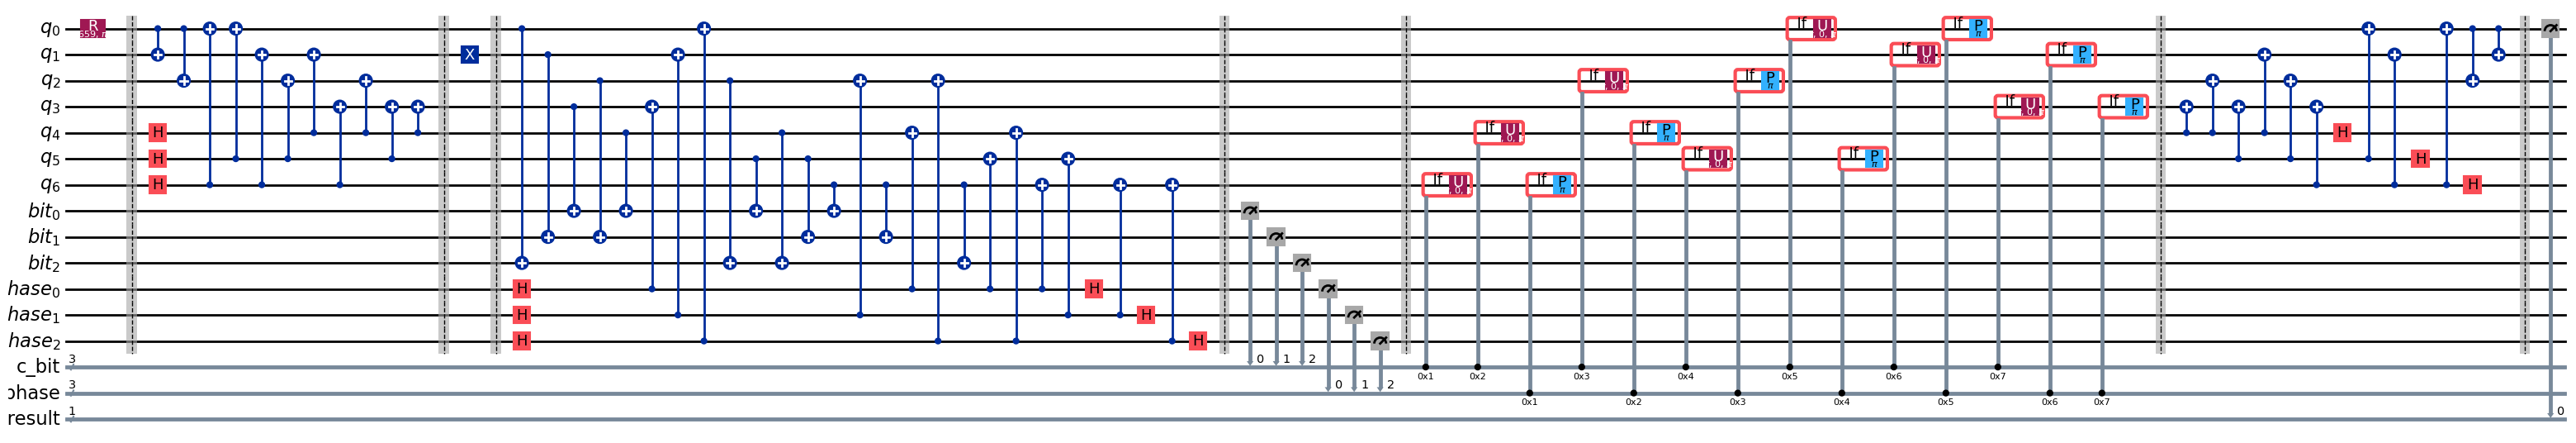

In [ ]:

# circuit plotting
fig = qc.decompose().draw("mpl", fold=-1)
fig.set_size_inches(40, 12)
fig